# Find Jaccard Distance Threshold

Find the Jaccard distance threshold between correct and incorrect
- MISOS address matches
- National Park name matches

In [1]:
import io, nltk, requests
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
from htmldate import find_date
from matplotlib.lines import Line2D
from os import listdir
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu

# Demo 1: Michigan Secretary of State Offices

### Load ground truth

In [2]:
df_misos_gt = pd.read_csv('./ground_truth/MISOS_Branches.csv')

In [3]:
df_misos_gt.head()

,name,address
0,Adrian,"1040 S Winter Ste 2200, Adrian, MI 49221"
1,Albion,"308 S Superior St, Albion, MI 49224"
2,Allegan,"430 Western Ave, Allegan, MI 49010"
3,Alma,"1586 Wright Ave, Alma, MI 48801"
4,Alpena,"2666 US 23 South, Alpena, MI 49707"


### Load data to test

In [4]:
path_misos_yp = './yellowpages/state+of+michigan+secretary+of+state+office-MI-yellowpages-scraped-data.csv'
df_misos = pd.read_csv(path_misos_yp)

In [5]:
df_misos.head()

,rank,business_name,telephone,business_page,category,website,rating,street,locality,region,zipcode,listing_url
0,1,Michigan Secretary Of State Branch Office,(888) 767-6424,https://www.yellowpages.com/sparta-mi/mip/mich...,State Government,http://www.michigan.gov,2.0,534 S State St,Sparta,MI,49345,https://www.yellowpages.com/search?search_term...
1,2,State of Michigan Secretary of State Branch Of...,(888) 767-6424,https://www.yellowpages.com/adrian-mi/mip/stat...,State Government,http://expresssos.com,NaN,1040 S Winter St,Adrian,MI,49221,https://www.yellowpages.com/search?search_term...
2,3,"Michigan Department of State, Secretary of State",(888) 767-6424,https://www.yellowpages.com/brighton-mi/mip/mi...,Government Offices,NaN,NaN,9864 E Grand River Ste 130,Brighton,MI,48116,https://www.yellowpages.com/search?search_term...
3,4,State of Michigan Secretary of State Branch,(888) 767-6424,https://www.yellowpages.com/munising-mi/mip/st...,"State Government,City, Village & Township Gove...",NaN,NaN,NaN,Munising,MI,49862,https://www.yellowpages.com/search?search_term...
4,5,Secretary of State office,(888) 767-6424,https://www.yellowpages.com/traverse-city-mi/m...,"State Government,Vehicle License & Registratio...",http://expresssos.com,NaN,1759 Barlow St,Traverse City,MI,49686,https://www.yellowpages.com/search?search_term...


### Collect Jaccard distances.

For each test address, find the Jaccard distance to every ground truth address.
Collect the Jaccard distances for the matches in a separate list from the Jaccard distances for the non-matches.

Use NLTK for convenience.

In [6]:
jd_match, jd_non_match = [], []
for test_ind in df_misos.index:
    test_address = df_misos.street[test_ind]
    try:
        test_chars = set(nltk.ngrams(test_address, n=3))
    except:
        continue # skip this cell if NaN i.e. value not available
    for ind in df_misos_gt.index:
        address = df_misos_gt.address[ind]
        address_chars = set(nltk.ngrams(address, n=3))
        jd = nltk.jaccard_distance(test_chars, address_chars)
        
        # if the test address and gt address are actually supposed to match
        if df_misos_gt.name[ind] in df_misos.locality[test_ind]:
            print(round(jd, 2), '\t', address)
            print(df_misos_gt.name[ind])
            jd_match.append(jd)
        else:
            jd_non_match.append(jd)

0.62 	 534 S State St, Sparta, MI 49345
Sparta
0.63 	 1040 S Winter Ste 2200, Adrian, MI 49221
Adrian
0.76 	 1759 Barlow St PO Box 6220, Traverse City, MI 49686
Traverse City
0.64 	 164 E. Columbia Ave, Belleville, MI 48111
Belleville
0.66 	 672 N Milford Rd, Highland, MI 48357
Highland
0.58 	 21572 Ecorse Rd, Taylor, MI 48180
Taylor
0.59 	 31164 Beck Rd, Novi, MI 48377
Novi
0.56 	 8565 N Lilley Rd, Canton, MI 48187
Canton
0.72 	 7 Vans Ave, Coldwater, MI 49036
Coldwater
0.71 	 5211 Cherry Avenue Plaza Suite 140, Hudsonville, MI 49426
Hudsonville
0.68 	 305 Ludington, Escanaba, MI 49829
Escanaba
1.0 	 5420 Beckley Road, Suite L, Battle Creek, MI 49015
Battle Creek
0.71 	 50640 Schoenherr Rd Summit Center, Shelby Township, MI 48315
Shelby Township
0.77 	 2887 Krafft Rd Court of Flags Mall, Port Huron, MI 48060
Port Huron
0.69 	 2565 S Gladwin Rd PO Box 169, Prudenville, MI 48651
Prudenville
0.62 	 37015 S Gratiot Ave, Clinton Township, MI 48036
Clinton Township
0.57 	 1007 N Euclid Ave,

### Visualize the distribution of Jaccard distances.

In [7]:
colors = ['xkcd:green','xkcd:pink']

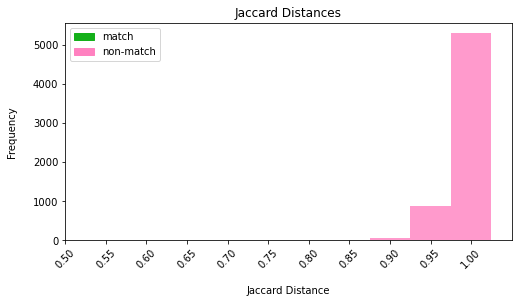

In [8]:
width = 0.05
plt.figure(figsize=(8, 4))
plt.title('Jaccard Distances')
plt.hist([jd_match, jd_non_match], bins=np.arange(0, 1+width, width)+width/2, color=colors, alpha=0.8, stacked=True)

p_match = mpatches.Patch(color=colors[0], label='match')
p_non_match = mpatches.Patch(color=colors[1], label='non-match')
plt.legend(handles=[p_match, p_non_match], loc='upper left')

plt.xticks(np.arange(0, 1+width, width), rotation=45)
plt.xlabel('\nJaccard Distance')
plt.ylabel('Frequency\n')
plt.xlim(0.5, 1+width)
plt.show()

### Zooming in on the vertical axis...

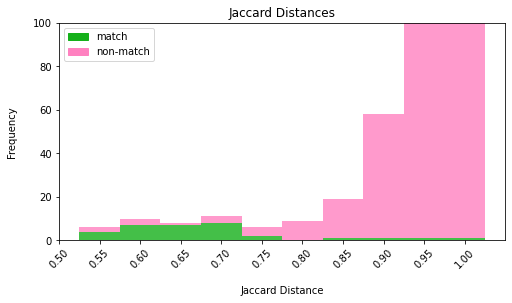

In [9]:
width = 0.05
plt.figure(figsize=(8, 4))
plt.title('Jaccard Distances')
plt.hist([jd_match, jd_non_match], bins=np.arange(0, 1+width, width)+width/2, color=colors, alpha=0.8, stacked=True)

p_match = mpatches.Patch(color=colors[0], label='match')
p_non_match = mpatches.Patch(color=colors[1], label='non-match')
plt.legend(handles=[p_match, p_non_match], loc='upper left')

plt.xticks(np.arange(0, 1+width, width), rotation=45)
plt.xlabel('\nJaccard Distance')
plt.ylabel('Frequency\n')
plt.xlim(0.5, 1+width)
plt.ylim(0, 100)
plt.show()

**Observation:** The distribution looks bimodal. Can we programmatically find a good threshold between the modes?

### Identify a threshold between the match and non-match Jaccard distances.
- Use 1D k-means (k = 2)
- Use Otsu's method

In [10]:
total_list = jd_match + jd_non_match

In [11]:
total_array = np.asarray(total_list)
km = KMeans(n_clusters=2).fit(total_array.reshape(-1, 1))
cluster_centers = km.cluster_centers_
thresh_kmeans = (cluster_centers[0][0]+cluster_centers[1][0])/2
thresh_kmeans

0.8434284310061535

In [12]:
thresh_otsu = threshold_otsu(total_array)
thresh_otsu

0.8410247093023255

In [13]:
thresh_manual = 0.775

### Visualize the distribution of Jaccard distances with the k-means, otsu, and manually determined thresholds.

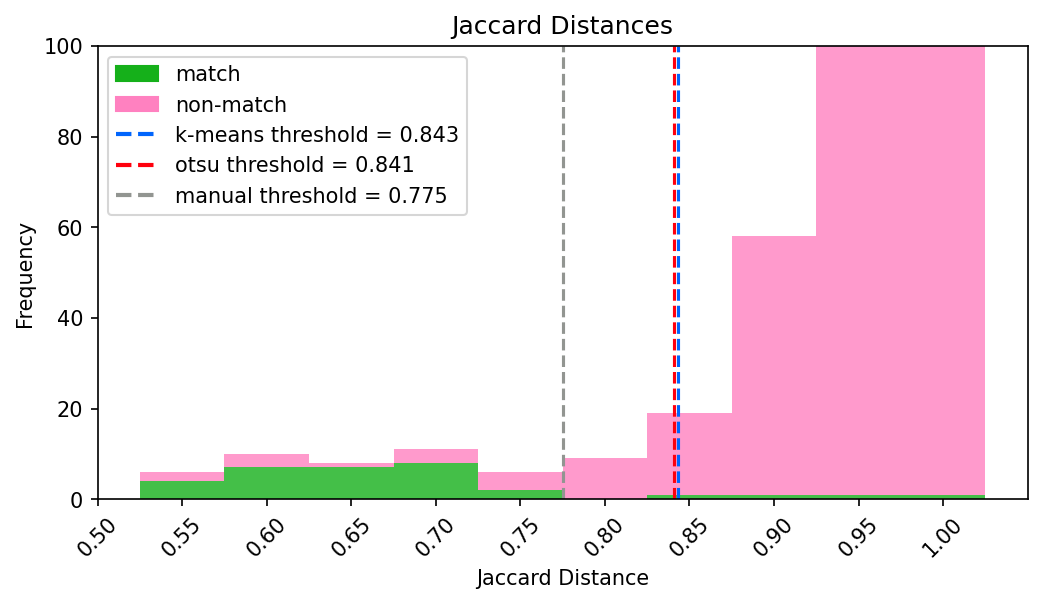

In [16]:
width = 0.05
plt.figure(figsize=(8, 4), dpi=150)
plt.hist([jd_match, jd_non_match], bins=np.arange(0, 1+width, width)+width/2, color=colors, alpha=0.8, stacked=True)
plt.axvline(thresh_kmeans, color='xkcd:bright blue', ls='--')
plt.axvline(thresh_otsu, color='xkcd:bright red', ls='--')
plt.axvline(thresh_manual, color='xkcd:gray', ls='--')

p_match = mpatches.Patch(color=colors[0], label='match')
p_non_match = mpatches.Patch(color=colors[1], label='non-match')
p_thresh_kmeans = Line2D([0], [0], color='xkcd:bright blue',linewidth=2, ls='--', label='k-means threshold = %s' % round(thresh_kmeans, 3))
p_thresh_otsu = Line2D([0], [0], color='xkcd:bright red', linewidth=2, ls='--', label='otsu threshold = %s' % round(thresh_otsu, 3))
p_thresh_manual = Line2D([0], [0], color='xkcd:gray', linewidth=2, ls='--', label='manual threshold = %s' % round(thresh_manual, 3))

plt.legend(handles=[p_match, p_non_match, p_thresh_kmeans, p_thresh_otsu, p_thresh_manual],
           loc='upper left')

plt.xticks(np.arange(0, 1+width, width), rotation=45)
plt.title('Jaccard Distances')
plt.xlabel('Jaccard Distance')
plt.ylabel('Frequency')
plt.ylim(0, 100)
plt.xlim(0.5, 1+width)
plt.show()

**Observation:** The k-means and otsu thresholds are about the same. The manually-found threshold minimizes false positives (detected matches that are actually not matches, i.e. amount of pink on the left side of the threshold line).

# Demo 2: US National Parks

In [17]:
df_gt = pd.read_csv('./ground_truth/national_parks_labeled.csv')
df_wikidata = pd.read_csv('./wikidata/national_parks_sparql_labeled.csv')

### Collect Jaccard distances.

In [18]:
jd_match, jd_non_match = [], []
for test_ind in df_wikidata.index:
    test_val = df_wikidata.entity_subclass_P31Label[test_ind]
    try:
        test_chars = set(nltk.ngrams(test_val, n=3))
    except:
        continue # skip this cell if NaN i.e. value not available
    for ind in df_gt.index:
        gt_val = df_gt.name[ind]
        gt_chars = set(nltk.ngrams(gt_val, n=3))
        jd = nltk.jaccard_distance(test_chars, gt_chars)
        
        # if the test value and gt value are actually supposed to match
        if test_val==gt_val:
            print(round(jd, 2), '\t', gt_val)
            print(df_gt.name[ind])
            jd_match.append(jd)
        else:
            jd_non_match.append(jd)

0.0 	 Acadia National Park
Acadia National Park
0.0 	 Acadia National Park
Acadia National Park
0.0 	 Arches National Park
Arches National Park
0.0 	 Badlands National Park
Badlands National Park
0.0 	 Big Bend National Park
Big Bend National Park
0.0 	 Big Bend National Park
Big Bend National Park
0.0 	 Biscayne National Park
Biscayne National Park
0.0 	 Black Canyon of the Gunnison National Park
Black Canyon of the Gunnison National Park
0.0 	 Bryce Canyon National Park
Bryce Canyon National Park
0.0 	 Canyonlands National Park
Canyonlands National Park
0.0 	 Capitol Reef National Park
Capitol Reef National Park
0.0 	 Carlsbad Caverns National Park
Carlsbad Caverns National Park
0.0 	 Channel Islands National Park
Channel Islands National Park
0.0 	 Congaree National Park
Congaree National Park
0.0 	 Crater Lake National Park
Crater Lake National Park
0.0 	 Cuyahoga Valley National Park
Cuyahoga Valley National Park
0.0 	 Death Valley National Park
Death Valley National Park
0.0 	 Dr

In [19]:
total_list = jd_match + jd_non_match
total_array = np.asarray(total_list)
km = KMeans(n_clusters=2).fit(total_array.reshape(-1, 1))
cluster_centers = km.cluster_centers_
thresh_kmeans = (cluster_centers[0][0]+cluster_centers[1][0])/2
thresh_otsu = threshold_otsu(total_array)
thresh_manual = 0.3

### Visualize the distribution of Jaccard distances with the k-means, otsu, and manually determined thresholds.

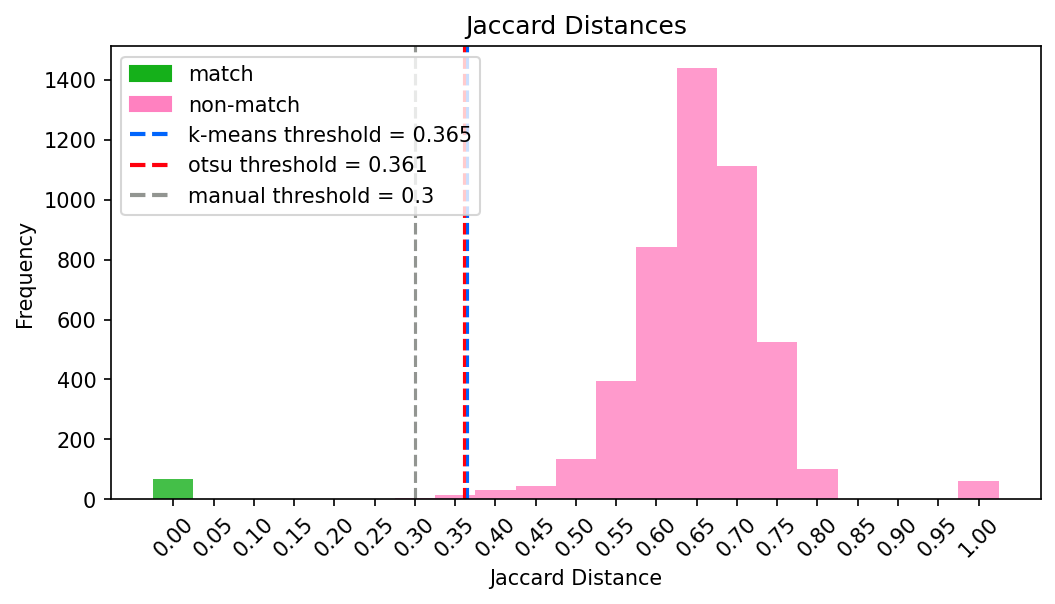

In [20]:
width = 0.05
plt.figure(figsize=(8, 4), dpi=150)
plt.hist([jd_match, jd_non_match], bins=np.arange(-width, 1+width, width)+width/2, color=colors, alpha=0.8, stacked=True)
plt.axvline(thresh_kmeans, color='xkcd:bright blue', ls='--')
plt.axvline(thresh_otsu, color='xkcd:bright red', ls='--')
plt.axvline(thresh_manual, color='xkcd:gray', ls='--')

p_match = mpatches.Patch(color=colors[0], label='match')
p_non_match = mpatches.Patch(color=colors[1], label='non-match')
p_thresh_kmeans = Line2D([0], [0], color='xkcd:bright blue',linewidth=2, ls='--', label='k-means threshold = %s' % round(thresh_kmeans, 3))
p_thresh_otsu = Line2D([0], [0], color='xkcd:bright red', linewidth=2, ls='--', label='otsu threshold = %s' % round(thresh_otsu, 3))
p_thresh_manual = Line2D([0], [0], color='xkcd:gray', linewidth=2, ls='--', label='manual threshold = %s' % round(thresh_manual, 3))

plt.legend(handles=[p_match, p_non_match, p_thresh_kmeans, p_thresh_otsu, p_thresh_manual],
           loc='upper left')

plt.xticks(np.arange(0, 1+width, width), rotation=45)
plt.title('Jaccard Distances')
plt.xlabel('Jaccard Distance')
plt.ylabel('Frequency')
plt.show()